# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 2. Поиск по образцу.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы второй практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

practice_dir_path = '/content/drive/MyDrive/2025-Murzin-TimeSeriesCourse-main/practice/02 Similarity search'
os.chdir(practice_dir_path)

In [3]:
!pwd

/content/drive/MyDrive/2025-Murzin-TimeSeriesCourse-main/practice/02 Similarity search


Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [ ]:
#%load_ext autoreload
#%autoreload 2

Импортируйте библиотеки и модули, необходимые для реализации практической работы 2.

In [4]:
!pip install mass-ts
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 13.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import math
import timeit
import random
import mass_ts as mts
from IPython.display import display

from modules.distance_profile import brute_force
from modules.prediction import *
from modules.bestmatch import *
from modules.utils import *
from modules.plots import *

In [6]:
import matplotlib.pyplot as plt

def plot_bestmatch_results(ts: np.ndarray, query: np.ndarray, bestmatch_results: dict) -> None:
    """
    Visualize the best match results

    Parameters
    ----------
    ts: time series
    query: query
    bestmatch_results: output data found by the best match algorithm
    """

    # INSERT YOUR CODE
    # --- Попытка извлечь индекс лучшего совпадения ---
    best_idx = (
        bestmatch_results.get("index")
        or bestmatch_results.get("best_index")
        or (bestmatch_results.get("indices")[0] if isinstance(bestmatch_results.get("indices"), (list, np.ndarray)) else None)
    )

    # --- Попытка извлечь расстояние ---
    distance = (
        bestmatch_results.get("distance")
        or bestmatch_results.get("best_distance")
        or (bestmatch_results.get("distances")[0] if isinstance(bestmatch_results.get("distances"), (list, np.ndarray)) else None)
    )

    # Проверка наличия индекса
    if best_idx is None:
        raise ValueError(
            "Не удалось определить индекс совпадения. "
            "Убедитесь, что в bestmatch_results есть ключ 'index', 'best_index' или 'indices'."
        )

    # Извлекаем участок временного ряда, соответствующий лучшему совпадению
    match_segment = ts[best_idx:best_idx + len(query)]

    plt.figure(figsize=(12, 6))

    # Весь временной ряд
    plt.plot(ts, label="Временной ряд", color="gray", alpha=0.6)

    # Лучшее совпадение
    plt.plot(range(best_idx, best_idx + len(query)), match_segment,
             label=f"Лучшее совпадение (начало = {best_idx})", color="orange", linewidth=2)

    # Запрос (масштабированный для наглядного сравнения)
    plt.plot(range(best_idx, best_idx + len(query)),
             (query - np.mean(query)) / np.std(query) * np.std(match_segment) + np.mean(match_segment),
             label="Запрос (масштабированный)", color="blue", linestyle="--")

    # Заголовок
    if distance is not None:
        plt.title(f"Лучшее совпадение (расстояние = {distance:.4f})")
    else:
        plt.title("Лучшее совпадение")

    plt.xlabel("Время")
    plt.ylabel("Значение")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## **Часть 1.** Поиск по образцу на основе вычисленного профиля расстояния.

**Задача поиска по образцу (subsequence matching)** заключается в нахождении $topK$ наиболее похожих подпоследовательностей временного ряда $T$ длины $n$ на заданный пользователем существенно более короткий временной ряд $Q$ длины $m$, называемый запросом, в смысле некоторой функции расстояния, $m \ll n$. При этом среди найденных подпоследовательностей не должно быть тривиальных совпадений.

Две подпоследовательности $T_{i,m}$ и $T_{j,m}$ временного ряда $T$ являются **тривиальными совпадениями (trivial matches)**, если они пересекаются:
\begin{equation}
|i-j| \leqslant m.
\end{equation}

В общем случае условие пересечения записывается как $|i-j| \leqslant \xi m$, где задаваемый экспертом вещественный параметр $\xi$ $(0 < \xi \leqslant 1)$ имеет типичные значения 0.25, 0.5 или 1.

Одним из вариантов решения данной задачи является вычисление профиля расстояния. Под **профилем расстояния** $DistProfile\in \mathbb{R}^{n-m+1}$ понимается вектор, содержащий расстояния между подпоследовательностями временного ряда $T \in \mathbb{R}^n$ и запросом $Q \in \mathbb{R}^m$, вычисленные с помощью некоторой неотрицательной симметричной функции расстояния $dist(\cdot,\cdot)$:  
\begin{equation}
DistProfile(i) = dist(Q, T_{i,m}), \quad 1 \leqslant i \leqslant n-m+1.
\end{equation}

На основе вычисленного профиля расстояния в качестве $topK$ похожих подпоследовательностей ряда берутся те, которые имеют наименьшие расстояния до запроса:
\begin{equation}
C_{match} = \{T_{i,m}^k\}_{k=1}^{topK},\; где \; T_{i,m}^k \in T, \; i = argsort(DistProfile)(k), \; 1 \leqslant i \leqslant n-m+1.
\end{equation}

В части 1 практической работы 2 вы рассмотрите несколько алгоритмов вычисления профиля расстояния на примере алгоритмов грубой силы и MASS, а также примените результаты их выполнения для решения задачи поиска по образцу. В таблице ниже представлено их тезисное описание.

| <h5> **Алгоритм** </h5> | <h5> **Описание** </h5> | <h5> **Вычислительная <br> сложность** </h5> |
|--------------|------------------------------------------------------------------|:-----------------------------:|
| <p>Brute Force</p>  | <ul><li>Наивный алгоритм</li><li>Z-нормализация запроса и подпоследовательностей ряда по стандартным формулам</li><li>Полное вычисление расстояний между запросом и подпоследовательностями ряда</li></ul> |            <p>$O(mn)$</p>            |
| <p>MASS 1</p>       | <ul><li>Z-нормализация &#171;на лету&#187;</li><li>Применение свертки для вычисления скалярных произведений <br> между запросом и подпоследовательностями ряда</li><li>Выполнение свертки с помощью быстрого преобразования Фурье</li><li>Дополнение справа нулями запроса и временного ряда до удвоенной длины ряда</li><li>Реверс запроса</li></ul> |          <p>$O(n\log{n})$</p>          |
| <p>MASS 2</p>       | <ul><li>MASS 1 – это алгоритм, на котором основан MASS 2</li><li>Вычисление половины свертки</li><li>Дополнение нулями справа только запроса до длины временного ряда</li></ul> |          <p>$O(n\log{n})$</p>          |
| <font size="3">MASS 3</font>       | <ul><li>MASS 2 – это алгоритм, на котором основан MASS 3</li><li>Посегментная обработка временного ряда</li><li>Длина каждого сегмента (кроме, возможно, последнего) – степень двойки</li><li>Сегменты перекрываются на $m-1$ элементов</li></ul> |             <p>$O(\frac{n-k}{k-m}k\log{k})$, <br> где $k$ – длина сегмента </p>           |

### **Задача 1.**

В данном задании вам предстоит определить, имеет ли пациент заболевание сердца по снятой записи ЭКГ или нет. Решать данную задачу будем с помощью алгоритмов поиска по образцу.

Сначала выполните считывание временного ряда и образца поиска из файлов *ECG.csv* и *ECG_query.csv* соответственно из директории *./datasets/part1*. Временной ряд представляет собой показания ЭКГ пациента, образец поиска – фрагмент ЭКГ, обозначающий некоторое кардиологическое заболевание.

In [7]:
ts_url = './datasets/part1/ECG.csv'
query_url = './datasets/part1/ECG_query.csv'

ts = read_ts(ts_url).reshape(-1)
query = read_ts(query_url).reshape(-1)

/content/drive/MyDrive/2025-Murzin-TimeSeriesCourse-main/practice/02 Similarity search/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

/content/drive/MyDrive/2025-Murzin-TimeSeriesCourse-main/practice/02 Similarity search/modules/utils.py:20: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



Далее выполните визулизацию временного ряда и образца поиска с помощью функции `plot_bestmatch_data()` из модуля *plots.py*.

In [8]:
plot_bestmatch_data(ts, query)

Реализуйте алгоритм грубой силы (brute force), заполнив одноименную функцию в модуле *distance_profile.py* недостающим кодом. Для этого воспользуйтесь псевдокодом алгоритма, который представлен ниже. После того как вычислен профиль расстояния, найдите $topK$ похожих подпоследовательностей на запрос с помощью функции `topK_match()` из *bestmatch.py*. Для исключения попадания тривиальных совпадений зададим $\xi = 0.5$ Далее параметр $\xi$ будем обозначать в коде как $excl\_zone\_frac$, а величину пересечения как $excl\_zone$, $excl\_zone = \lceil excl\_zone\_frac \cdot m \rceil$,

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/brute_force.png?raw=true" width="400"></center>

In [9]:
topK = 2
excl_zone_frac = 0.5
excl_zone = math.ceil(len(query) * excl_zone_frac)
is_normalize = True

naive_bestmatch_results = {}

# INSERT YOUR CODE

In [10]:
# Вычисление профиля расстояний
dist_profile = brute_force(ts, query, is_normalize)

# Поиск topK совпадений
naive_bestmatch_results = topK_match(dist_profile, excl_zone, topK)

Напишите функцию `plot_bestmatch_results()` в модуле *plots.py* для визуализации найденных $topK$ похожих подпоследовательностей временного ряда на образец поиска. За основу возьмите функцию `plot_bestmatch_data()` и добавьте отображение найденных подпоследовательностей, выделив их тем же цветом, что и образец поиска.

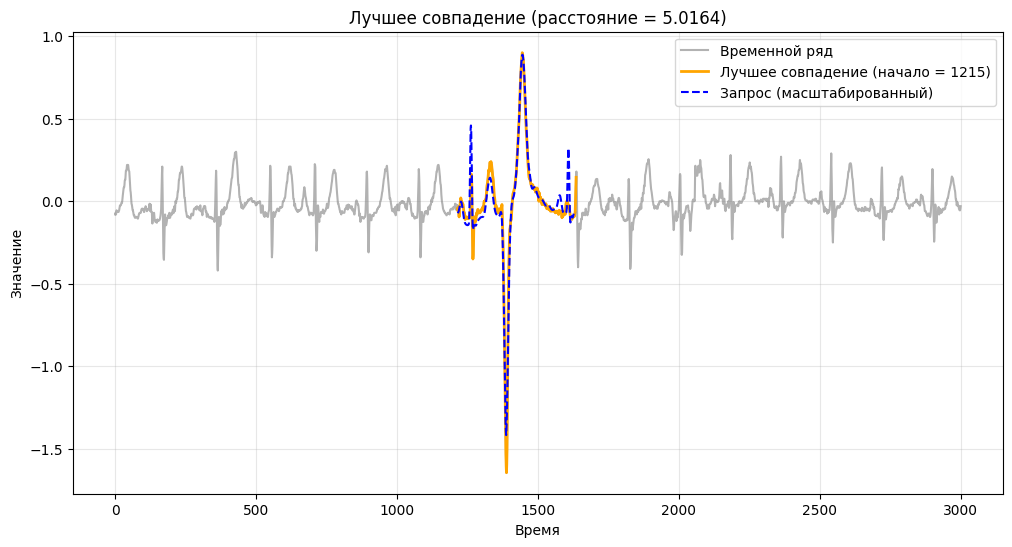

In [11]:
# Визуализация результатов
plot_bestmatch_results(ts, query, naive_bestmatch_results)

In [12]:

print(naive_bestmatch_results['distances'])

[np.float64(5.016417971728833), np.float64(18.030850173768773)]


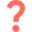
Определите по полученным результатам, имеет ли человек сердечное заболевание или нет.

Если смотреть на графики, мы можем судить о том, что человек имеет сердечное заболевание

### **Задача 2.**

Проделайте такие же шаги для поиска по образцу, как и в задаче 1, но теперь вычислите профиль расстояния с помощью одной из выбранных вами версий алгоритма MASS. Для этого используйте стороннюю библиотеку *mass-ts*. Со списком всех функций, которые предоставляет данная библиотека, и их описанием вы можете ознакомиться в [репозитории библиотеки GitHub](https://github.com/matrix-profile-foundation/mass-ts).

Обратите внимание, что MASS 2 и MASS 3 возвращают профиль расстояния в виде вектора комплексных чисел. Для дальнейшей работы с профилем расстояния используйте только вещественные части комплексных чисел.     

In [ ]:
# INSERT YOUR CODE

In [13]:
import numpy as np
import math
from modules.bestmatch import topK_match

topK = 2
excl_zone_frac = 0.5
excl_zone = math.ceil(len(query) * excl_zone_frac)

# Вычисление профиля расстояний с MASS2
dist_profile_mass = np.real(mts.mass2(ts, query))  # Берём вещественную часть

print(f"Длина профиля расстояний: {len(dist_profile_mass)}")
print(f"Минимальное расстояние: {np.min(dist_profile_mass)}")
print(f"Первые 10 значений профиля: {dist_profile_mass[:10]}")


Длина профиля расстояний: 2580
Минимальное расстояние: 5.016417971728845
Первые 10 значений профиля: [22.39707072 22.23816137 22.16184162 22.18146561 22.30299975 22.51404647
 22.784649   23.10130126 23.46494551 23.84982694]


In [14]:
# Поиск topK совпадений
mass_bestmatch_results = topK_match(dist_profile_mass, excl_zone, topK)

print(f"Индексы совпадений: {mass_bestmatch_results['indices']}")
print(f"Расстояния: {mass_bestmatch_results['distances']}")

Индексы совпадений: [np.int64(1215), np.int64(193)]
Расстояния: [np.float64(5.016417971728845), np.float64(18.030850173768773)]


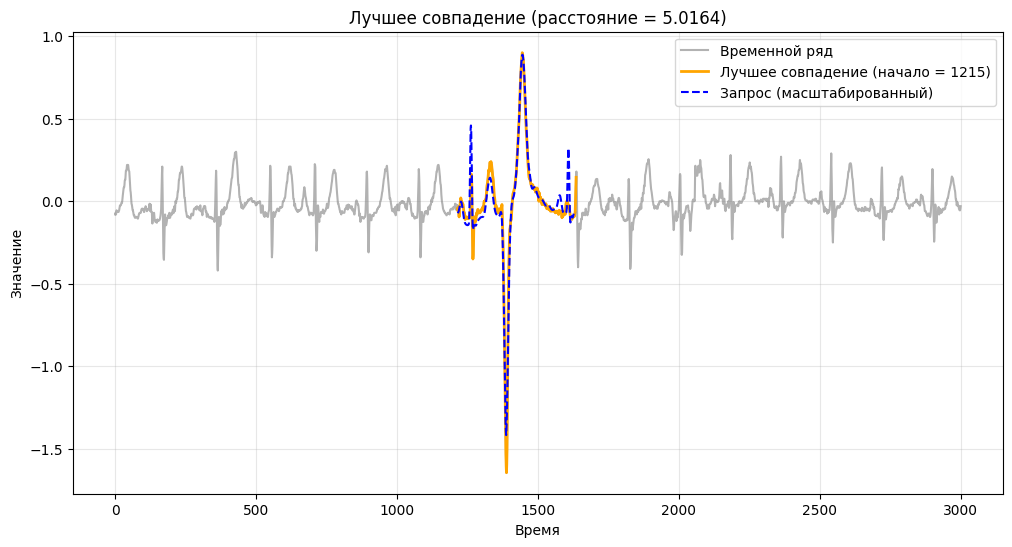

In [15]:
#from modules.plots import plot_bestmatch_results

# Визуализация
plot_bestmatch_results(ts, query, mass_bestmatch_results)

### **Задача 3.**

Проведите две серии экспериментов по сравнению быстродействия алгоритмов грубой силы и трех версий MASS:
1. на фиксированной длине запроса $m$ при изменяемой длине временного ряда $n$;
2. на фиксированной длине временного ряда $n$ при изменяемой длине запроса $m$.

Все необходимые для проведения экспериментов функции находятся в модуле *experiments.py*.

Сначала сгенерируйте по аналогии временные ряды и запросы поиска различных длин, как это было сделано в практической работе 1. Далее измерьте время выполнения алгоритмов при заданных входных параметрах и данных с помощью функции `run_experiment()`. Полученные результаты (время выполнения) каждого эксперимента отобразите на линейном графике, воспользовавшись функцией `visualize_plot_times()`.

Также вычислите ускорение с помощью функции `calculate_speedup()`, показывающее, во сколько раз алгоритм MASS превосходит по времени выполнения алгоритма грубой силы, по следующей формуле:
\begin{equation}
speedup = \frac{t_{BF}}{t_{MASS}},
\end{equation}
где $t_{BF}$ и $t_{MASS}$ — время работы алгоритма грубой силы и MASS соответственно.

Полученные ускорения оформите в виде таблицы, для построения используйте функцию `visualize_table_speedup()`.

Эксперимент 1

In [8]:
import numpy as np
from modules.utils import random_walk
from modules.experiments import run_experiment, visualize_plot_times, calculate_speedup, visualize_table_speedup

In [15]:

tt = 10000

algorithms = ['brute_force', 'mass', 'mass2', 'mass3']
algorithms_params = {
    'brute_force': None,
    'mass': None,
    'mass2': None,
    'mass3': {'segment_len': 2048},
}

n_list = [2**15, 2**16, 2**17, 2**18, 2**19, 2**20] # lengths of time series
m = 128 # length of query

exp1_params = {
    'varying': {'n': n_list},
    'fixed': {'m': m}
}

exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'distance_profile'

# generate set of time series and query
# run experiments for measurement of algorithm runtimes

# INSERT YOUR CODE

# Генерация данных
for n in n_list:
    exp1_data['ts'][str(n)] = random_walk(n)
exp1_data['query'][str(m)] = random_walk(m)

print("Генерация завершена")

Генерация завершена


In [17]:
# Измерение времени выполнения
times_exp1 = {}
for alg in algorithms:
    times_exp1[alg] = run_experiment(alg, task, exp1_data, exp1_params, algorithms_params.get(alg))

# Преобразование в массив для визуализации
times_array_exp1 = np.array([times_exp1[alg] for alg in algorithms])

In [18]:
# visualize plot with results of experiment
comparison_param = np.array(algorithms)

# INSERT YOUR CODE

In [19]:
visualize_plot_times(times_array_exp1, comparison_param, exp1_params)

In [20]:
# visualize table with speedup
tab_index = algorithms[1:]
tab_columns = [f"n = {n}" for n in n_list]
tab_title = "Speedup MASS relative to the brute force <br> (variable time series length, fixed query length)"

# INSERT YOUR CODE

In [21]:
# Вычисление ускорения
base_times = times_exp1['brute_force']
improved_times = [times_exp1[alg] for alg in algorithms[1:]]  # Исключаем Brute Force
speedup_data = calculate_speedup(base_times, improved_times)
visualize_table_speedup(speedup_data*tt, tab_index, tab_columns, tab_title)

,n = 32768,n = 65536,n = 131072,n = 262144,n = 524288,n = 1048576
mass,1311279.939529,1576391.060673,1481268.161731,987100.299883,1133572.648112,891484.496031
mass2,431703.129334,395181.260090,418687.460226,465206.787860,529446.637690,367226.734724
mass3,263386.722288,287062.819365,362964.224645,293988.741992,329122.597314,208752.740372


Эксперимент 2

In [22]:
m_list = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10] # lengths of queries
n = 2**15 # length of time series

exp2_params = {
    'varying': {'m': m_list},
    'fixed': {'n': n}
}

exp2_data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), [])
}

# INSERT YOUR CODE

In [23]:
task = 'distance_profile'

# Генерация данных
exp2_data['ts'][str(n)] = random_walk(n)
for m in m_list:
    exp2_data['query'][str(m)] = random_walk(m)

print("Данные для второго эксперемента получены")

# Измерение времени выполнения
times_exp2 = {}
for alg in algorithms:
    times_exp2[alg] = run_experiment(alg, task, exp2_data, exp2_params, algorithms_params.get(alg))

# Преобразование в массив для визуализации
times_array_exp2 = np.array([times_exp2[alg] for alg in algorithms])

Данные для второго эксперемента получены


In [24]:
# Визуализация результатов эксперимента
comparison_param = np.array(algorithms)
visualize_plot_times(times_array_exp1, comparison_param, exp1_params)

In [25]:
# Вычисление ускорения
base_times = times_exp2['brute_force']
improved_times = [times_exp2[alg] for alg in algorithms[1:]]  # Исключаем Brute Force
speedup_data = calculate_speedup(base_times, improved_times)

In [26]:
# Визуализация таблицы ускорения
tab_index = algorithms[1:]  # ['mass', 'mass2', 'mass3']
tab_columns = [f"m = {m}" for m in m_list]
tab_title = "Speedup MASS relative to the brute force (variable query length, fixed time series length)"
visualize_table_speedup(speedup_data*tt, tab_index, tab_columns, tab_title)


,m = 32,m = 64,m = 128,m = 256,m = 512,m = 1024
mass,1004995.505617,978618.966108,1027591.317197,1166153.613882,1315332.507158,2022088.472381
mass2,739926.402422,431242.262852,294740.778916,174804.162537,106293.957067,85867.594339
mass3,587844.880395,403405.906467,265063.693555,157834.382979,99093.724794,81119.459233


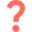
Проанализируйте и изложите содержательный смысл полученных
результатов.

*# WRITE YOUR ANSWER*

Алгоритмы MASS показывают лучшее быстродействие по сравнению с алгоритмом грубой силы.

## **Часть 2.** Ускорение вычисления DTW меры техникой ограничения полосы Сако—Чиба. Наивный алгоритм поиска по образцу на основе DTW меры.

### **Задача 4.**

Поскольку DTW мера имеет квадратичную вычислительную сложность от
длины временного ряда $O(n^2)$, то в данном задании вам предстоит реализовать технику ограничения полосы Сако–Чиба. Данная техника не позволяет отклоняться пути трансформации более чем на $r$ ячеек от диагонали матрицы трансформации и тем самым сокращает вычисление меры до $O(rn)$.

Добавьте в функцию `DTW_distance()` из модуля *metrics.py* возможность ограничения полосы Сако—Чиба. Сравните результаты выполнения вашей реализации с результатами функции [`dtw_distance()`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*, задав различные значения параметра $r$ (например, от 0 до 1 с шагом 0.05).

**Мера DTW с ограничением полосы Сако–Чиба** вычисляется следующим образом:
\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = (t_{1,i} - t_{2,j})^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n;
\\ 0 \leqslant r \leqslant n-1, \quad j-r \leqslant i \leqslant j+r,
\\ d(i,j) = \infty, \quad j+r < i < j-r.
\end{equation}

In [9]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [10]:
from sktime.distances import dtw_distance
from modules.metrics import DTW_distance

# INSERT YOUR CODE

In [11]:
T1 = random_walk(10)
T2 = random_walk(10)

for r in range(0, 101, 5):
    dist1 = DTW_distance(T1, T2, r=r/100.)
    dist2 = dtw_distance(T1, T2, window=r/100.)

    test_distances(dist1, dist2)

### **Задача 5.**

Реализуйте самостоятельно наивный алгоритм поиска $topK$ подпоследовательностей временного ряда, похожих на образец поиска в смысле меры DTW. Для этого уже подготовлен шаблон класса `NaiveBestMatchFinder` в модуле *bestmatch.py*. Напишите метод `perform()`, выполняющий обнаружение подпоследовательностей ряда, похожих на образец поиска. Метод должен избегать попадания в результирующее множество пересекающихся подпоследовательностей. Для этого используйте функцию `topK_match()`. При реализации опирайтесь на псевдокод наивного алгоритма поиска, который представлен ниже.

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/naive_algorithm.png?raw=true" width="550"></center>

Для этой задачи используйте временной ряд и запрос ЭКГ из части 1. Если они не загружены, то выполните их считывание из соответствующих файлов.

In [12]:
topK = 2
r = 0.01
excl_zone_frac = 0.5
is_normalize = True

naive_bestmatch_results = {}

# INSERT YOUR CODE

naive_best_match_finder = NaiveBestMatchFinder(excl_zone_frac, topK, is_normalize, r)

naive_bestmatch_results = naive_best_match_finder.perform(ts, query)

naive_bestmatch_results

{'indices': [np.int64(1214), np.int64(192)],
 'distances': [np.float64(13.926217775336447), np.float64(192.9575116412412)]}

Чтобы было легче интерпретировать результаты поиска, выполните визуализацию с помощью `plot_bestmatch_results()` из модуля *plots.py*.

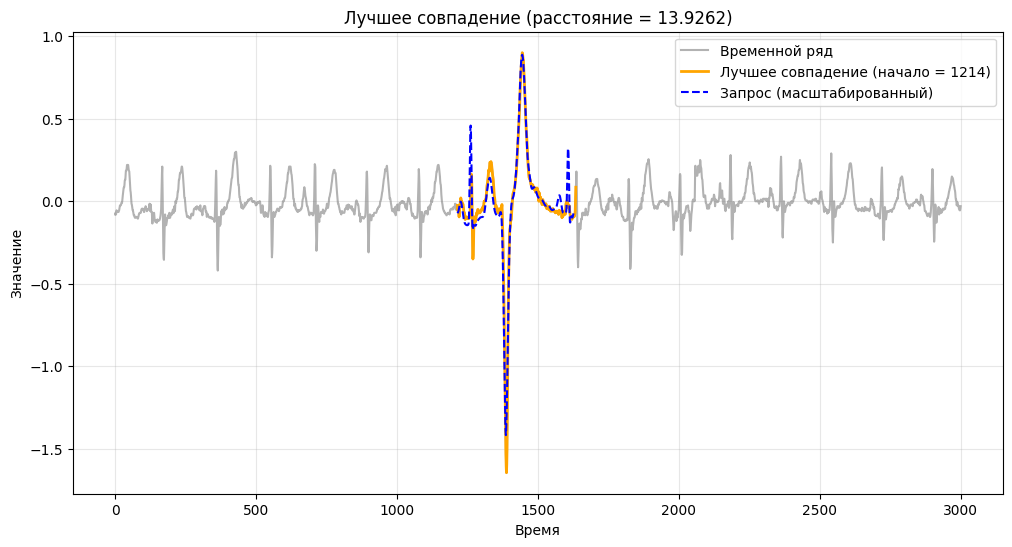

In [12]:
plot_bestmatch_results(ts, query, naive_bestmatch_results)

### **Задача 6**.

Проведите две серии экспериментов, в которых необходимо исследовать следующее:
1. влияние длины запроса $m$ и ширины полосы Сако—Чиба $r$ на время выполнения наивного алгоритма при фиксированной длине ряда $n$;
2. влияние длины ряда $n$ и ширины полосы Сако—Чиба $r$ на время выполнения наивного алгоритма при фиксированной длине запроса $m$.

Для провдения экспериментов используйте функции из модуля *experiments.py*.
Эксперименты проведите на синтетических временных рядах и запросах указанных длин. Полученные результаты каждого эксперимента отобразите на линейном графике.

Эксперимент 1

In [13]:
algorithm = 'naive'
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15] # lengths of time series
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
m = 2**6 # length of query

exp1_params = {
    'varying': {'n': n_list,
                'r': r_list},
    'fixed': {'m': m}
}
exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'best_match'

# generate set of time series and query
# run experiments for measurement of algorithm runtimes

# INSERT YOUR CODE

In [14]:
for n in n_list:
    exp1_data['ts'][str(n)] = random_walk(n)

exp1_data['query'][str(m)] = random_walk(m)

times_exp1 = run_experiment(algorithm, task, exp1_data, exp1_params, alg_params=algorithm_params)
times_exp1 = np.array(times_exp1)
times_exp1

array([[  0.263034  ,   0.51325214,   0.57252467,   1.23762543,
          2.343008  ,   4.90435422],
       [  0.92914252,   3.46711236,   3.90546089,   9.5197829 ,
         17.59155298,  36.87174748],
       [  1.54769279,   3.29983504,   8.59564267,  15.72906622,
         31.65699512,  65.49037801],
       [  2.23237463,   6.4114915 ,  11.10894083,  22.09265655,
         46.52088796,  92.99432448],
       [  2.75283217,   5.85298074,  13.98722671,  28.33010436,
         57.54706431, 112.76115512],
       [  3.66510068,   8.19745261,  16.14217735,  34.62218458,
         67.2402253 , 134.83640534]])

In [15]:
# visualize plot with results of experiment
comparison_param = np.array(r_list)

# INSERT YOUR CODE

In [16]:
visualize_plot_times(times_exp1, comparison_param, exp1_params)

Эксперимент 2

In [17]:
m_list = [2**4, 2**5, 2**6, 2**7, 2**8] # lengths of query
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
n = 2**12 # length of time series

exp2_params = {
    'varying': {'m': m_list,
                'r': r_list},
    'fixed': {'n': n}
}
exp2_data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), []),
}

# INSERT YOUR CODE

In [18]:
exp2_data['ts'][str(n)] = random_walk(n)

for m in m_list:
    exp2_data['query'][str(m)] = random_walk(m)

times_exp2 = run_experiment(algorithm, task, exp2_data, exp2_params, alg_params=algorithm_params)
times_exp2 = np.array(times_exp2)
times_exp2

array([[  0.8064695 ,   0.38646821,   0.59768112,   0.94219051,
          1.70096027],
       [  0.42039224,   1.99608488,   4.68719638,  15.01464499,
         57.45948021],
       [  0.6910962 ,   3.42092397,   7.28945477,  29.47405967,
        111.81332321],
       [  0.78641476,   2.73631848,  11.36925593,  41.41880507,
        152.30805109],
       [  1.88623774,   3.91378045,  13.63962187,  52.71103428,
        193.45664207],
       [  1.21247123,   5.66126547,  16.09413126,  61.8169879 ,
        223.30967825]])

In [19]:
comparison_param = np.array(r_list)

# INSERT YOUR CODE

In [20]:
visualize_plot_times(times_exp2, comparison_param, exp2_params)

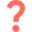
Проанализируйте и изложите содержательный смысл полученных
результатов.

*# WRITE YOUR ANSWER*

Ширина полосы Сако-Чиба влияет на быстродействие вычислений. Чем значение ближе к нулю, тем быстрее выполняется программа. Чем ближе к 1, тем медленее.

## **Часть 3.** Алгоритм UCR-DTW.

Третья часть практической работы посвящена алгоритму UCR-DTW, который использует нижние границы схожести $\text{LB}_{\text{Kim}}\text{FL}$, $\text{LB}_{\text{Keogh}}\text{EQ}$ и $\text{LB}_{\text{Keogh}}\text{EC}$, применяющиеся каскадным образом. Псевдокод алгоритма UCR-DTW представлен ниже.

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/ucr_dtw.png?raw=true" width="650"></center>

**Нижняя граница схожести (lower bound, LB)** представляет собой функцию, вычислительная сложность которой меньше вычислительной сложности меры DTW. Нижняя граница используется для отбрасывания кандидатов (подпоследовательностей временного ряда), заведомо не похожих на запрос, без вычисления меры DTW.

Нижние границы между кандидатом
$C$ и запросом $Q$ длины $n$, применяемые в UCR-DTW, вычисляются следующим образом:
<ul>
<li><b>Нижняя граница $\text{LB}_{\text{Kim}}\text{FL}$</b> определяется как сумма квадратов разностей между первыми и последними точками запроса $Q$ и
подпоследовательности $C$:
\begin{equation}
    \text{LB}_{\text{Kim}}\text{FL}(Q, C) = (q_1 - c_1)^2 + (q_n - c_n)^2.
\end{equation}
</li>

<li><b>Нижняя граница $\text{LB}_{\text{Keogh}}\text{EQ}$</b> показывает расстояние между верхней или нижней оболочкой $U$ и $L$, построенными вокруг запроса $Q$, и кандидатом $C$:
\begin{equation}
    \text{LB}_{\text{Keogh}}\text{EQ}(Q,C) = \sum_{i=1}^n{\left\{
            \begin{array}{cl}
            (c_i - u_i)^2, & \text{if} \; c_i > u_i \\
            (c_i - l_i)^2, & \text{if} \; c_i < l_i\\
            0, & \text{otherwise}.
            \end{array}
            \right.}
\end{equation}

Нижней и верхней оболочкой (lower and upper envelope) запроса $Q$ называют соответственно последовательности $L = (l_1,..., l_n)$ и $U = (u_1,..., u_n)$, вычисляемые как минимумы и максимумы запроса в скользящем окне заданной длины $r$ ($1 < r < m$):
\begin{equation}
    u_i = \max_{\max(1,i-r) \leqslant k \leqslant \min(m, i+r)} q_{k}, \\
    l_i = \min_{\max(1,i-r) \leqslant k \leqslant \min(m, i+r)} q_{k},
\end{equation}
где $r$ – ширина полосы Сако–Чиба.
</li>

<li><b>Нижняя граница $\text{LB}_{\text{Keogh}}\text{EC}$</b> представляет собой расстояние между запросом $Q$ и оболочкой кандидата $C$, т.е. является реверс-версией нижней границы $\text{LB}_{\text{Keogh}}\text{EQ}$:
\begin{equation}
    \text{LB}_{\text{Keogh}}\text{EC}(Q,C) = \text{LB}_{\text{Keogh}}\text{EQ}(C, Q).
\end{equation}
</li>
</ul>

### **Задача 7.**
  
Реализуйте технику каскадного применения нижних границ и сами нижние границы,  заполнив пропуски в классе `UCR_DTW`, в модуле *bestmatch.py*.
Выполните алгоритм UCR-DTW на данных ЭКГ из предыдущих частей, задав такие же значения входных параметров, что и для наивного алгоритма из части 2, и визуализируйте результаты. Убедитесь, что результаты UCR-DTW совпадают с результатами наивного алгоритма.

In [ ]:
top_k = 2
r = 0.01
excl_zone_frac = 1
is_normalize = True

ucr_dtw_results = {}

# INSERT YOUR CODE

Визуализируйте количество неотброшенных и отброшенных каждой нижней границей подпоследовательностей временного ряда в виде круговой диаграммы с помощью функции `pie_chart()` из модуля *plots.py*.

In [ ]:
# INSERT YOUR CODE

### **Задача 8.**

Проведите эксперименты, аналогичные тем, которые выполнялись для исследования эффективности наивного алгоритма в задаче 6. Постройте графики и вычислите ускорение алгоритма UCR-DTW относительно наивного алгоритма. Для справедливого сравнения алгоритмов используйте сгенерированные временные ряды и запросы из задачи 6.

Эксперимент 1

In [ ]:
algorithm = 'ucr-dtw'
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15] # lengths of time series
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
m = 2**6 # length of query

exp1_params = {
    'varying': {'n': n_list,
                'r': r_list},
    'fixed': {'m': m}
}
exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'best_match'

# generate set of time series and query
# run experiments for measurement of algorithm runtimes

# INSERT YOUR CODE

In [ ]:
#visualize plot with results of experiment
comparison_param = np.array(r_list)

# INSERT YOUR CODE

In [ ]:
# visualize table with speedup
tab_index = [f"n = {n}" for n in n_list]
tab_columns = [f"r = {r}" for r in r_list]
tab_title = "Speedup UCR-DTW relative to the naive algorithm <br> (variable time series length and warping path size, fixed query length)"

# INSERT YOUR CODE

Эксперимент 2

In [ ]:
m_list = [2**4, 2**5, 2**6, 2**7, 2**8] # lengths of query
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
n = 2**12 # length of time series

exp_params = {
    'varying': {'m': m_list,
                'r': r_list},
    'fixed': {'n': n}
}
data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), []),
}

# INSERT YOUR CODE

In [ ]:
comparison_param = np.array(r_list)

# INSERT YOUR CODE

In [ ]:
tab_index = [f"m = {m}" for m in m_list]
tab_columns = [f"r = {r}" for r in r_list]
tab_title = "Speedup UCR-DTW relative to the naive algorithm <br> (variable query length and warping path size, fixed time series length)"

# INSERT YOUR CODE

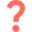
Проанализируйте и изложите содержательный смысл полученных
результатов.

*# WRITE YOUR ANSWER*

### **Задача 9.**

В данном задании вам предстоит определелить, какую функцию расстояния ED или DTW лучше всего использовать на практике для поиска наиболее похожих подпоследовательностей временного ряда на запрос. Чтобы это сделать, рассмотрим две задачи из различных предметных областей, решить которые предлагается с помощью алгоритмов поиска по образцу.

Начнем с **первой задачи из области физиологии человека**. На человеке сначала закрепляют множество акселерометров и гироскопов, после чего он выполняет в помещении последовательность заранее определенных действий (активностей) в течение некоторого промежутка времени. Примерами таких активностей являются открывание/закрывание дверей, включение/выключение света, питье из чашки стоя/сидя и др. В то время как человек выполняет эти активности, датчики фиксируют его скорость и направление наклона тела. Задача дата-сайентиста заключается в том, что необходимо распознать в снятых данных все активности, которые выполнял человек.  

Данную задачу упростим, и будем выполнять поиск только одной активности во временном ряде при условии, что у нас имеется образец этой активности. В качестве данных возьмем временной ряд показаний гироскопа, закрепленного на правом запятье руки человека, из набора данных [Opportunity](https://archive.ics.uci.edu/dataset/226/opportunity+activity+recognition) и образец искомой активности, питья из чашки стоя. Данный ряд соответствует примерно 14-минутной записи.

Загрузите временной ряд и образец поиска из директории `./datasets/part3/Opportunity` в ноутбук.    

In [ ]:
# INSERT YOUR CODE

Выполните поиск похожих подпоследовательностей на запрос с помощью реализованных вами ранее алгоритмов MASS и UCR-DTW. Согласно истинной разметке, искомую активность человек выполнял 7 раз, поэтому параметр $topK=7$.

In [ ]:
topK = 7
r = 0.1
excl_zone_frac = 1
is_normalize = True

# INSERT YOUR CODE

Чтобы оценить качество распознавания активности, загрузите имеющуюся истинную разметку, хранящуюся в файле *labels.csv*. В разметке значением 1 обозначаются моменты времени, когда человек пил из чашки стоя, и значением 0 – в противном случае. Вычислите среди найденных $topK$ подпоследовательностей количество TP (True Positive) и FN (False Negative) с помощью функции `calculate_task1_accuracy()` и сравните между собой показатели, полученные с помощью MASS и UCR-DTW.

In [ ]:
def calculate_task1_accuracy(labels: np.array, predicted_results: np.array) -> dict:
    """
    Calculate the accuracy of the algorithm which performs the activity recognition

    Parameters
    ----------
    labels: true labels
    predicted_results: results are predicted by algorithm

    Returns
    -------
        The number of True Positive and False Negative examples
    """

    TP = 0
    FN = 0

    topK = len(predicted_results['indices'])

    for i in range(topK):
        idx = predicted_results['indices'][i]
        if (labels[idx] == 1):
            TP = TP + 1

    FN = topK - TP

    return {'TP': TP,
            'FN': FN}

In [ ]:
# INSERT YOUR CODE

Итоговый вывод о преимуществе одной функции расстояния над другой в задаче поиска по образцу на данный момент делать еще рано, поэтому решим **вторую задачу из области транспорта**. Данная задача заключается в прогнозировании потока пешеходов в некоторой точке города на основе прошлых данных.

Прогнозирование ряда $T$ длины $n$ будем выполнять следующим образом. Сначала сформируем запрос $Q$, состоящий из $m$ последних по времени элементов ряда, $Q = T_{n-m+1,m}$. Далее среди всех подпоследовательностей ряда $T$, начинающихся с 1 до $n-2m$ позиций, найдем $topK$ похожих на запрос $Q$. Обозначим за $h > 0$ горизонт прогнозирования, определяющий количество элементов ряда, значения которых необходимо спрогнозировать. Для нахождения будущих значений будем брать $h$ элементов ряда, которые следуют за концевыми точками найденных похожих подпоследовательностей. В итоге, будущие значения будут получаться путем применения агрегатной функции к этим элементам. В качестве агрегатной функции может использоваться среднее арифметическое, взвешенное среднее, медиана и др.

Загрузите временной ряд из файла *pedestrian_count.csv*, расположенного в директории *./datasets/part3/Melbourne*. Данный ряд содержит почасовую статистику о количестве пешеходов на улице Бурке в Мельбурне (Австралия), являющейся одной из главных улиц города. Данные собраны за период с 1 марта 2020 по 31 октября 2022 гг. Полный набор данных и его детальное описание доступны по следующей [ссылке](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/).

In [ ]:
data_path = './datasets/part3/Melbourne/pedestrian_count.csv'

data = pd.read_csv(data_path, header=0)

Реализуйте алгоритм прогнозирования временного ряда на основе UCR-DTW и MASS, следуя приведенному выше описанию. За прогнозирование отвечает класс `BestMatchPredictor` из модуля *prediction.py*, дополните его недостающим кодом.  

Далее выполните прогнозирование потока людей для исходных данных на 1 день вперед (24 значения). Для этого установите следующие входные параметры:
<ul>
  <li>$h = 24$ (горизонт прогнозирования);</li>
  <li>$m = 168$ (длина запроса и подпоследовательностей, соответствующая 1 неделе);</li>
  <li>$aggr\_func = \text{'average'}$ (агрегатная функция);</li>
  <li>для алгоритма UCR-DTW:
    <ul>
      <li>$topK = 5$ (количество похожих подпоследовательностей на запрос);</li>
      <li>$r = 0.1$ (ширина полосы Сако–Чиба);</li>
      <li>$excl\_zone\_frac = 1$ (доля от длины подпоследовательностей, на основе которой определяется, являются ли подпоследоватлеьности тривиальными совпадениями);</li>
      <li>$is\_normalize = True$ ($z$-нормализация запроса и подпоследовательностей);</li>
    </ul>
  </li>
  <li>для алгоритма MASS:</li>
    <ul>
      <li>$topK = 5$ (количество похожих подпоследовательностей на запрос);</li>
      <li>$excl\_zone\_frac = 1$ (доля от длины подпоследовательностей, на основе которой определяется, являются ли подпоследоватлеьности тривиальными совпадениями).</li>
    </ul>
</ul>

Будем считать, что последние $h$ значений в загруженном временном ряде $T$ длины $n$ отсутствуют. Поэтому перед тем как находить прогнозные значения,  подготовьте данные. Разделите загруженный временной ряд $T$ на три части:
<ol>
  <li>ряд $T_{train}$, в котором будет выполняться поиск похожих подпоследовательностей на запрос $Q$: $T_{train} = T[0:(n-m-h)]$</li>
  <li>запрос $Q$: $Q = T[(n-m-h) : (n-h)]$</li>
  <li>реальные значения ряда $real\_values$, которые необходимо спрогнозировать: $real\_values = T[-h:] $</li>
</ol>

In [ ]:
ucr_dtw_params = {
    'topK': # INSERT VALUE,
    'r': # INSERT VALUE,
    'excl_zone_frac': # INSERT VALUE,
    'is_normalize': # INSERT VALUE
}

# INSERT YOUR CODE

In [ ]:
mass_params = {
    'topK': # INSERT VALUE,
    'excl_zone_frac': # INSERT VALUE
}

# INSERT YOUR CODE

Далее выполните сравнение эффективности алгоритма при UCR-DTW и MASS по точности прогнозирования. Для оценки точности используйте **меру
среднеквадратичной ошибки RMSE (Root Mean Square Error)**, которая определяется следующим образом:
\begin{equation}
RMSE = \sqrt{\frac{1}{h}\sum_{i=1}^h{(t_i-\tilde{t}_i)}^2},
\end{equation}
где $t_i$ и $\tilde{t}_i$ — фактическое и прогнозное значения элемента ряда, $h$ — количество прогнозных элементов временного ряда.

In [ ]:
from sklearn.metrics import mean_squared_error

# INSERT YOUR CODE

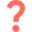 Сделайте вывод о влиянии функции расстояния ED и DTW на точность решения задач интеллектульного анализа данных, которые основаны на алгоритмах поиска по образцу.  

*# WRITE YOUR ANSWER*